# Exploratory Data Analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import sys

# Custom functions

sys.path.insert(1, '../src')
from custom_plots import *

import shap

# Options
pd.options.display.max_rows = 200
pd.options.display.max_columns = 200
%matplotlib inline
sns.set_theme(style="white")

# Convenience for working with external src code files
%load_ext autoreload
%autoreload 2

## Import protest data

In [2]:
# Import data from Modeling notebook
engine = create_engine('sqlite:///../data/processed/all_data.db')
with engine.begin() as connection:
    df = pd.read_sql('SELECT * FROM all_modeled_data', connection)
    
df['target_categorical'] = ['Revolution' if x == 1 else \
                            "No Revolution" for x in df.target]
#df.drop('target', axis=1, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14787 entries, 0 to 14786
Data columns (total 31 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   country                            14787 non-null  object 
 1   region                             14787 non-null  object 
 2   protestnumber                      14787 non-null  float64
 3   protesterviolence                  14787 non-null  float64
 4   startdate                          14787 non-null  float64
 5   participants                       14787 non-null  float64
 6   demand_labor-wage-dispute          14787 non-null  float64
 7   demand_land-farm-issue             14787 non-null  float64
 8   demand_police-brutality            14787 non-null  float64
 9   demand_political-behavior/process  14787 non-null  float64
 10  demand_price-increases/tax-policy  14787 non-null  float64
 11  demand_removal-of-politician       14787 non-null  flo

In [3]:
demands = ['demand_labor-wage-dispute', 'demand_land-farm-issue', 
           'demand_police-brutality', 'demand_political-behavior/process', 
           'demand_price-increases/tax-policy', 'demand_removal-of-politician', 
           'demand_social-restrictions']
binary = demands+['protesterviolence', 'military', 'legelec', 'exelec']

continuous = ['protestnumber', 'participants', 'yrsoffc', 
              'totalseats', 'startdate', 'liec', 'eiec', 'numvote', 'oppvote', 
              'tensys_strict', 'parcomp', 'parreg', 'xconst', 'xropen', 'xrcomp']
categorical = ['region', 'system', 'country']
targets = ['target', 'target_categorical']

remainders = df.drop(continuous+categorical+binary+targets, axis=1).columns

if remainders.shape==(0,):
    print("All features successfully bucketed")
else:
    print('Remaining columns to be assigned to various bucket:')
    for col in remainders:
        print(col, '\n', df[col].value_counts(), '\n')

All features successfully bucketed


## Correlation matrix

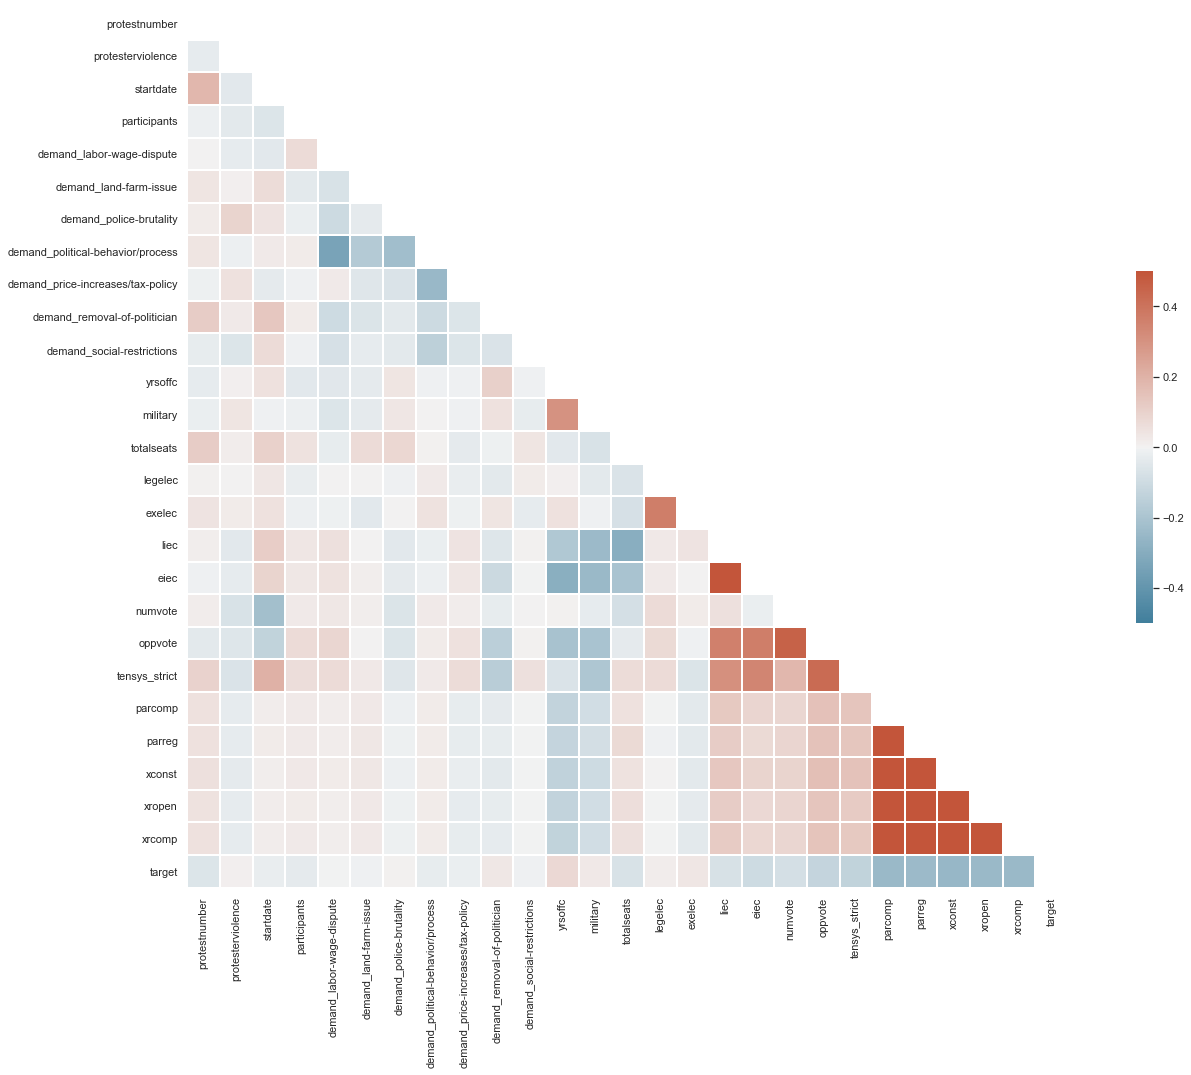

In [4]:
custom_plot_matrix(df, max_corr=0.5)

### Protestnumber

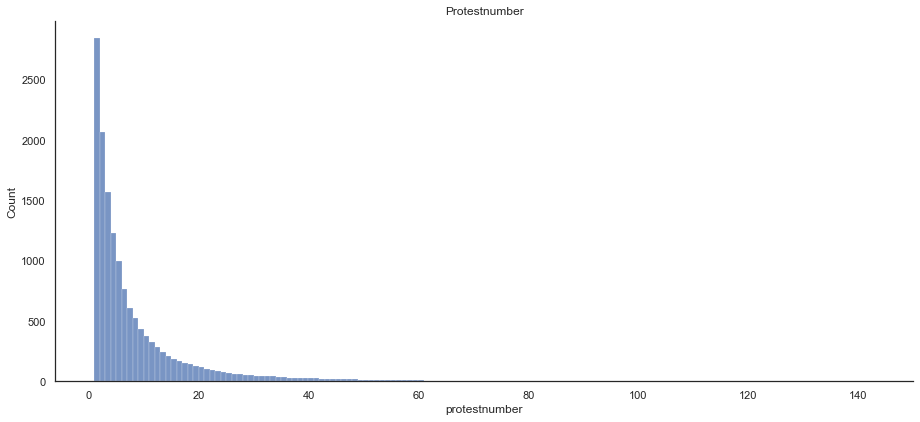

In [5]:
fig = sns.displot(df.protestnumber, 
                  bins=int(df.protestnumber.max()-df.protestnumber.min()))
fig.fig.set_figwidth(15)
fig.fig.set_figheight(6)
plt.title('Protestnumber');

### Protest start year

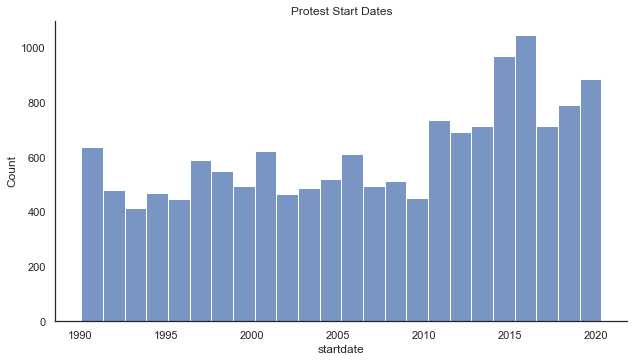

In [6]:
fig = sns.displot(df.startdate)
fig.fig.set_figwidth(10)
fig.fig.set_figheight(5)
plt.title('Protest Start Dates')
plt.savefig('../images/startdates.png');

### Protester Demands

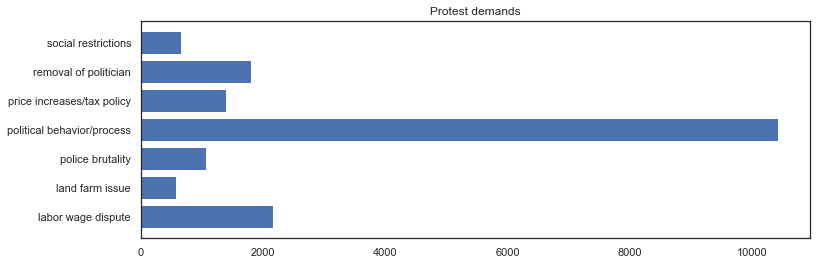

In [7]:
plt.figure(figsize=(12, 4))
bar = df[demands].sum()
cols = [x[7:].replace('-', ' ') for x in bar.index]
plt.barh(cols, bar.values)
plt.title('Protest demands')
plt.savefig('../images/protest_demands.png');

 **Target:** We see that the protester demand for "removal of politician" is most strongly correlated with an impending revolution. 

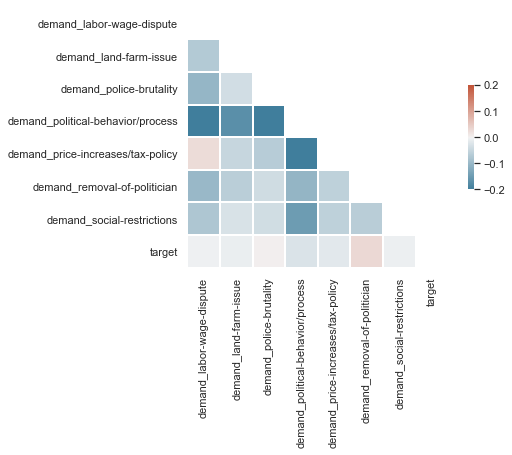

In [8]:
custom_plot_matrix(df[demands+targets], max_corr=0.2)

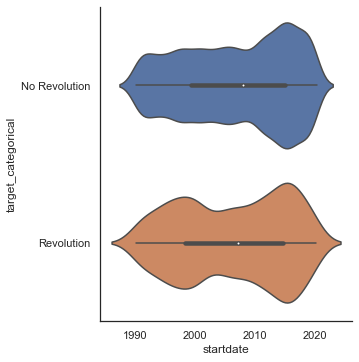

In [9]:
sns.catplot(x='startdate', y='target_categorical',kind="violin", data=df);

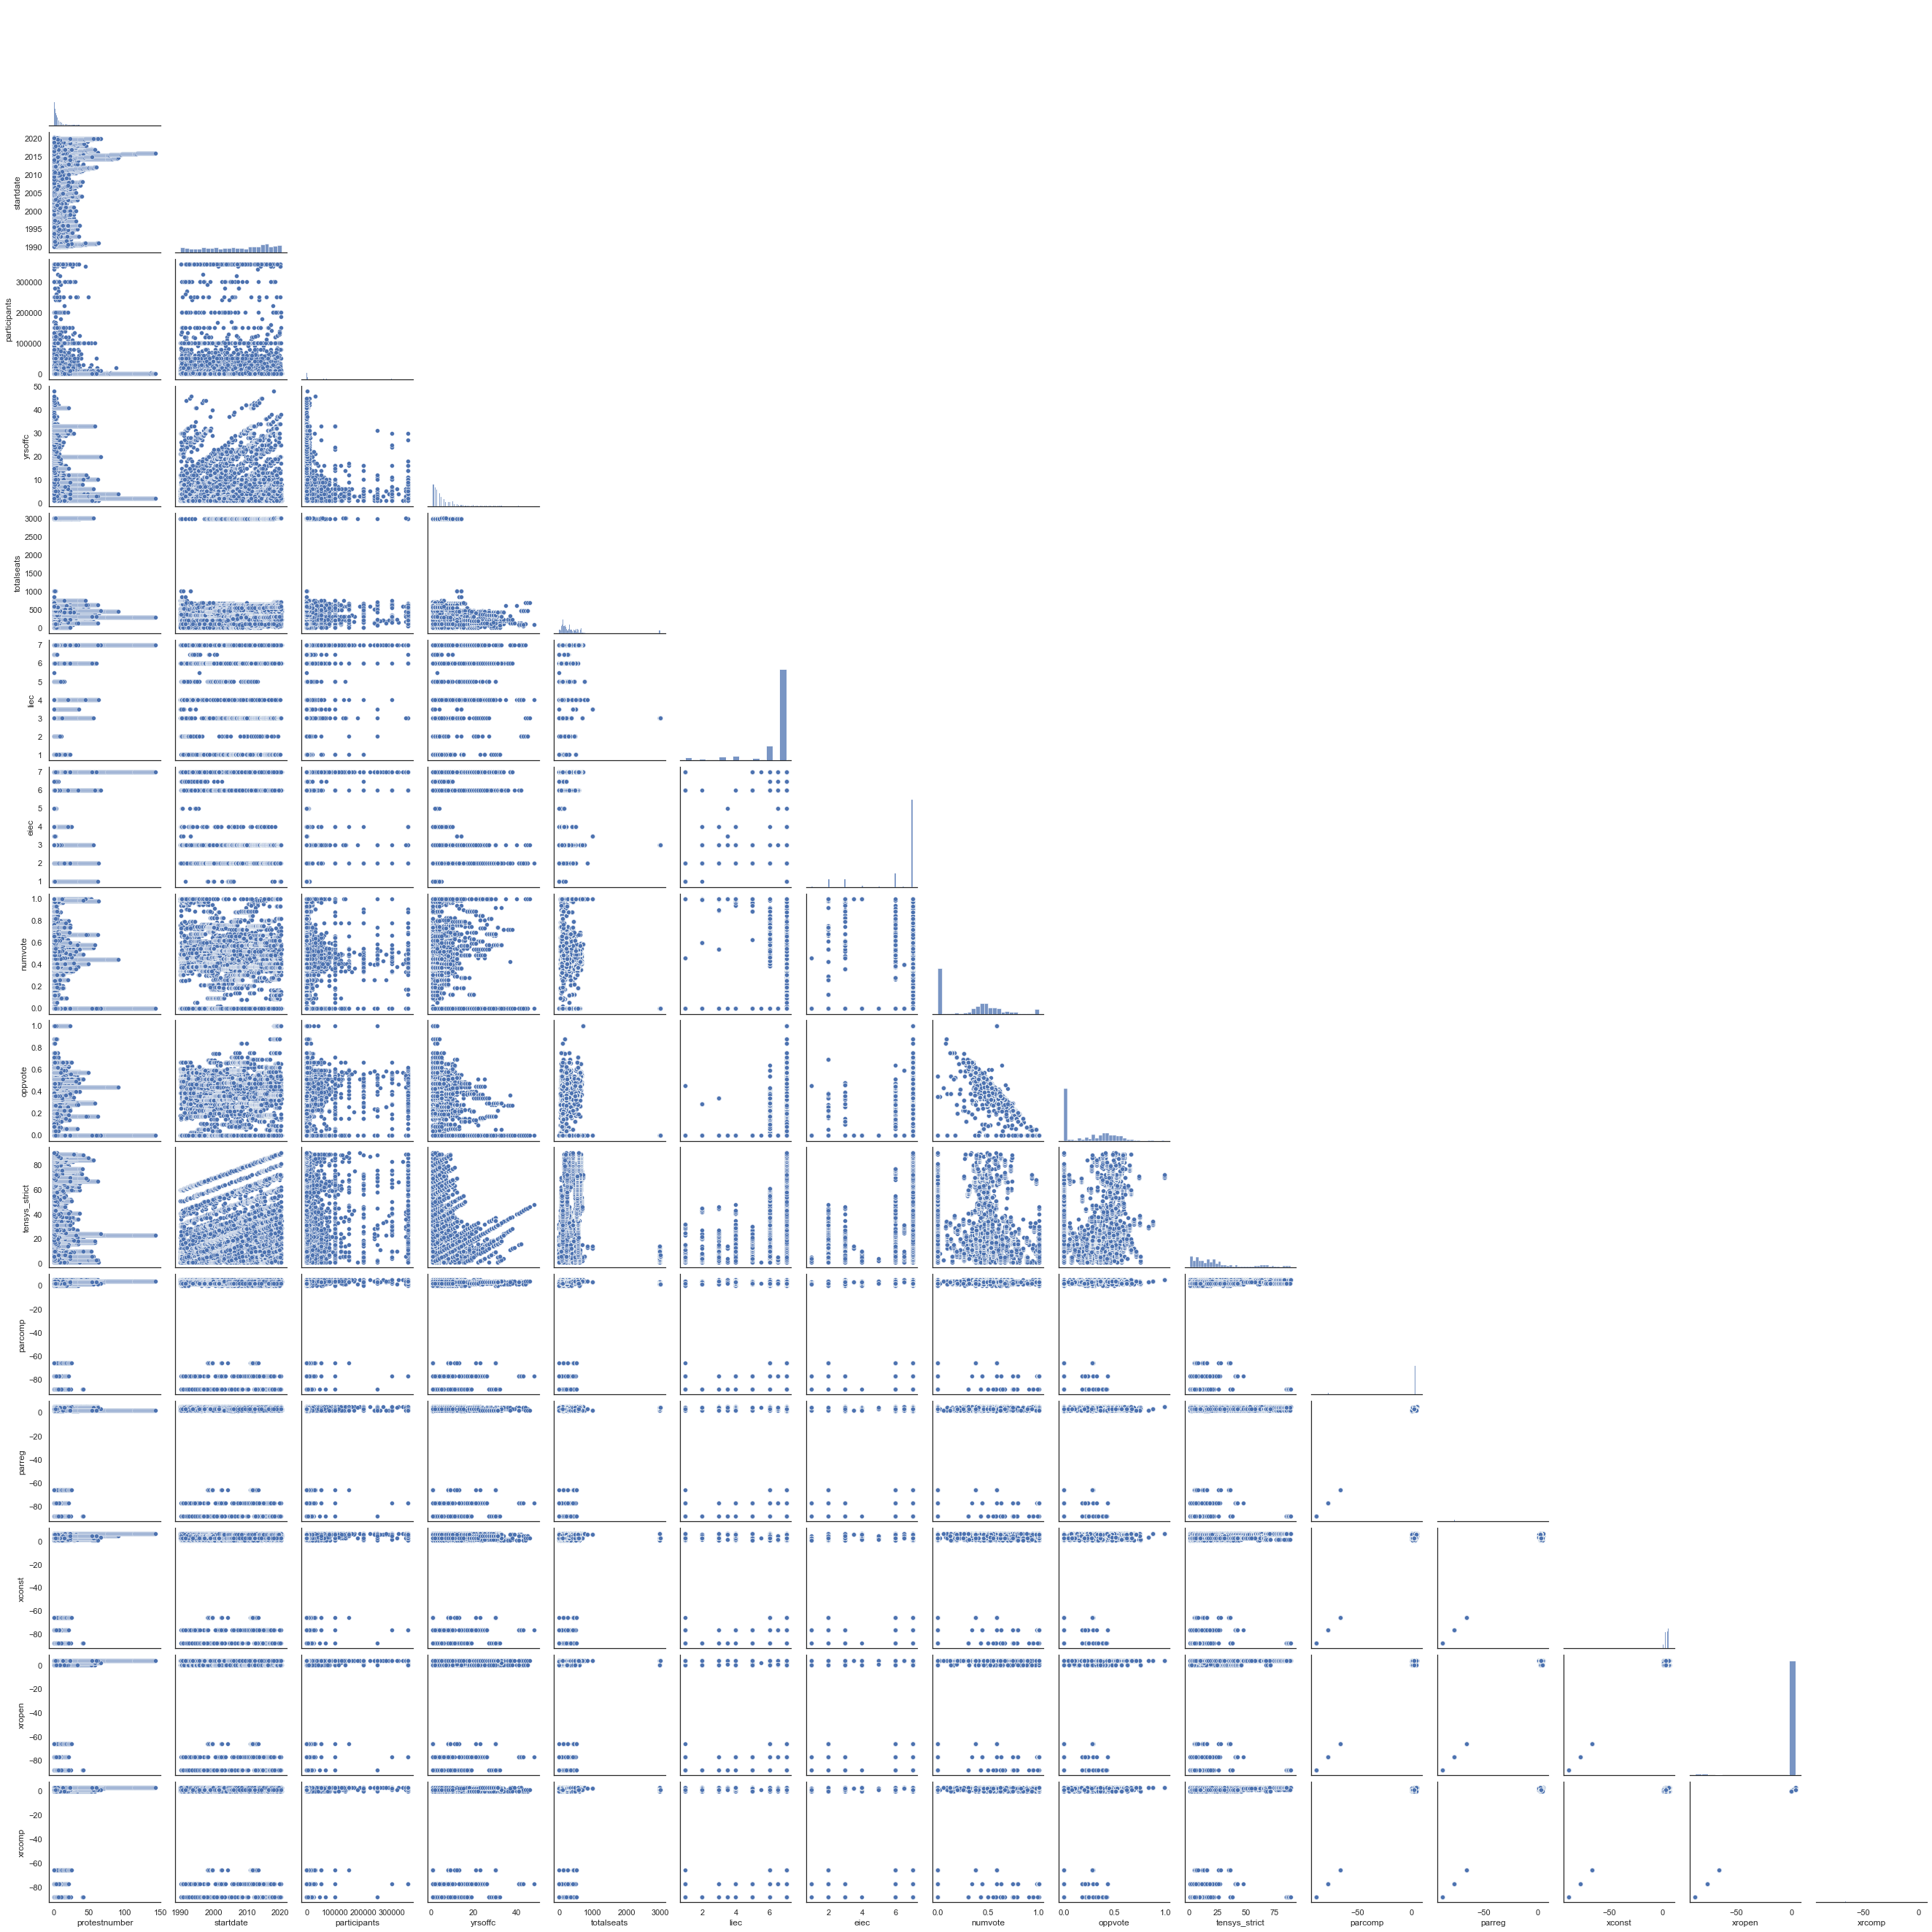

In [10]:
sns.pairplot(df.drop(binary+categorical+targets, axis=1), corner=True);

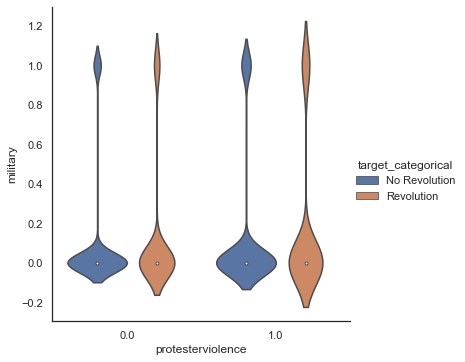

In [11]:
sns.catplot(y='military', x='protesterviolence',kind="violin", 
            hue='target_categorical', data=df);



#plt.scatter(data=df, x='startdate', y='participants')

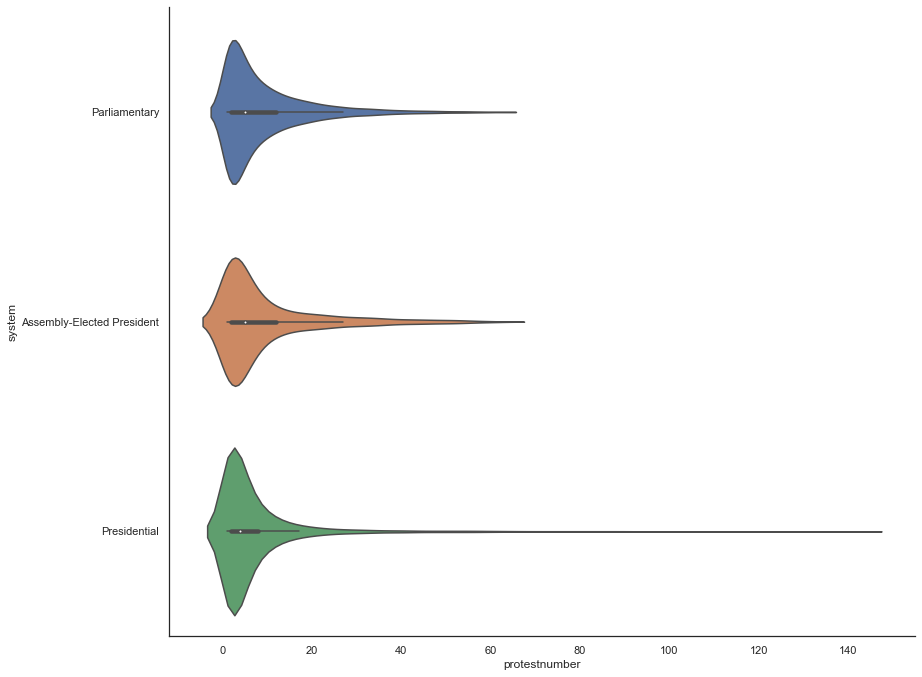

In [12]:
fig = sns.catplot(x='protestnumber', y='system',kind="violin", data=df)

fig.fig.set_figwidth(20)
fig.fig.set_figheight(10)

In [13]:
df.yrsoffc.mean()+3*df.yrsoffc.std()

25.62118116788023

In [14]:
high_end = df.totalseats.mean()+3*df.totalseats.std()
print('High end:', high_end)
df.loc[df.totalseats>high_end].totalseats.value_counts()

High end: 1640.8938616818357


2987.0    136
2978.0    114
3000.0     65
Name: totalseats, dtype: int64

In [15]:
df.totalseats.value_counts().head(30)

120.0     581
0.0       431
166.0     411
577.0     401
300.0     382
500.0     350
450.0     268
150.0     264
290.0     257
299.0     241
128.0     217
650.0     200
72.0      178
631.0     171
543.0     168
350.0     154
301.0     151
630.0     146
101.0     142
83.0      141
550.0     140
360.0     140
645.0     137
2987.0    136
296.0     135
400.0     133
130.0     126
513.0     125
207.0     122
125.0     117
Name: totalseats, dtype: int64

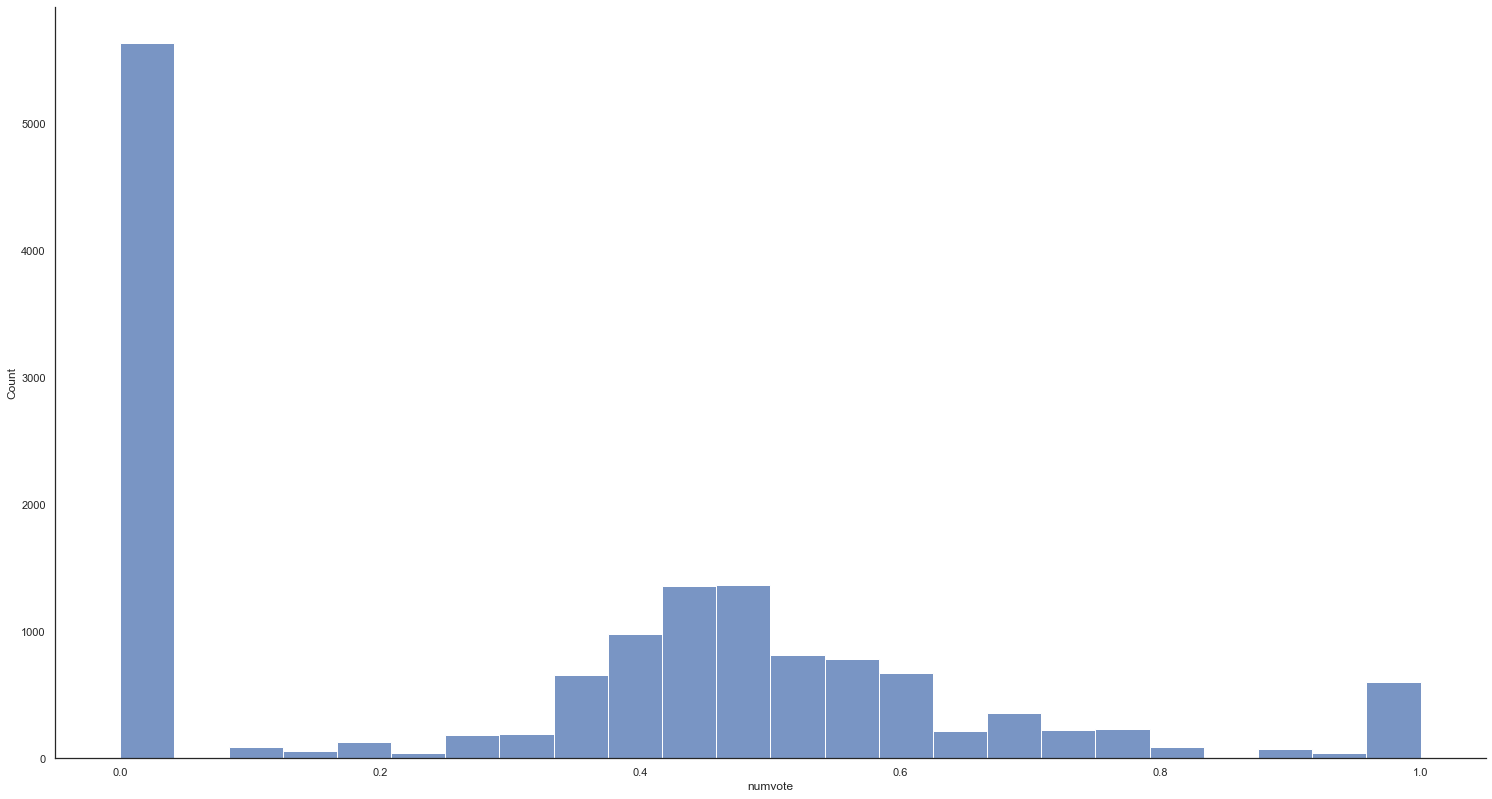

In [16]:
fig = sns.displot(df.numvote)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

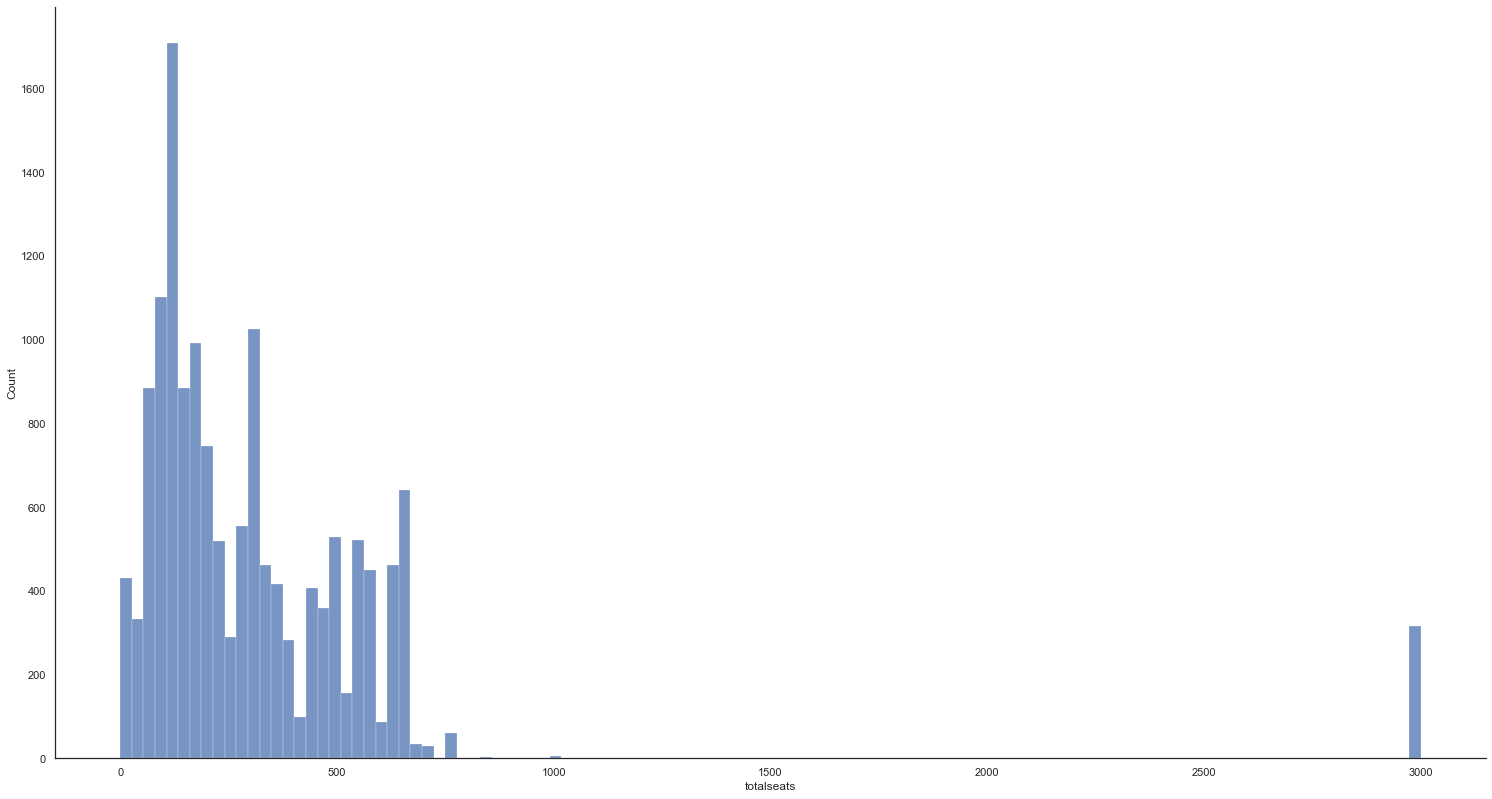

In [17]:
fig = sns.displot(df.totalseats)
fig.fig.set_figwidth(25)
fig.fig.set_figheight(12.5)

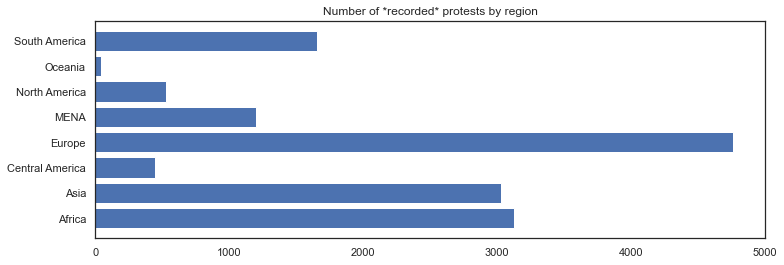

In [18]:
plt.figure(figsize=(12, 4))
protest_ct = pd.get_dummies(df.region).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by region');
plt.savefig('../images/protests_by_region.png');

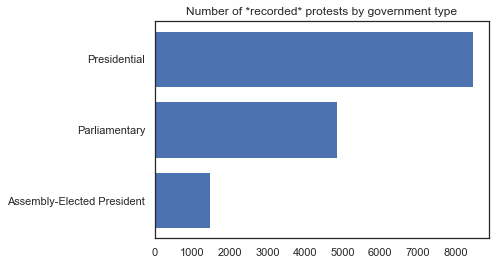

In [19]:
protest_ct = pd.get_dummies(df.system).sum()
plt.barh(protest_ct.index, protest_ct.values)
plt.title('Number of *recorded* protests by government type');

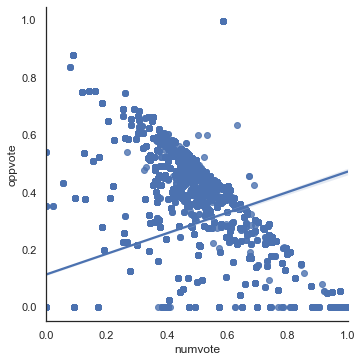

In [20]:
sns.lmplot(x='numvote', y='oppvote', data=df);